# Importing Libaraies

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import json

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import  accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings("ignore")

In [3]:
my_data_dir="/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images" 

In [4]:
os.listdir(my_data_dir)

['Uninfected', 'Parasitized']

## Create Datadrame with images

In [5]:
images = []
labels = []

for subfolder in os.listdir(my_data_dir):

    subfolder_path = os.path.join(my_data_dir, subfolder)
    if not os.path.isdir(subfolder_path):
        continue

    for image_filename in os.listdir(subfolder_path):
        if image_filename.endswith('.png'):
            image_path = os.path.join(subfolder_path, image_filename)
            images.append(image_path)
            labels.append(subfolder)

df = pd.DataFrame({'image_path': images, 'label': labels})


In [6]:
df = shuffle(df).reset_index(drop=True)

In [7]:
df.head()

,image_path,label
0,/kaggle/input/cell-images-for-detecting-malari...,Uninfected
1,/kaggle/input/cell-images-for-detecting-malari...,Uninfected
2,/kaggle/input/cell-images-for-detecting-malari...,Parasitized
3,/kaggle/input/cell-images-for-detecting-malari...,Parasitized
4,/kaggle/input/cell-images-for-detecting-malari...,Parasitized


# Visuilizations

In [8]:
# Use plotly to plot interactive bar chart
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x = df['label'].value_counts().index, y = df['label'].value_counts())])
fig.update_traces(marker_color = 'rgb(0,200,0)', marker_line_color = 'rgb(0,255,0)',
                  marker_line_width = 7, opacity = 0.6)
fig.show()

### Visulizing Images

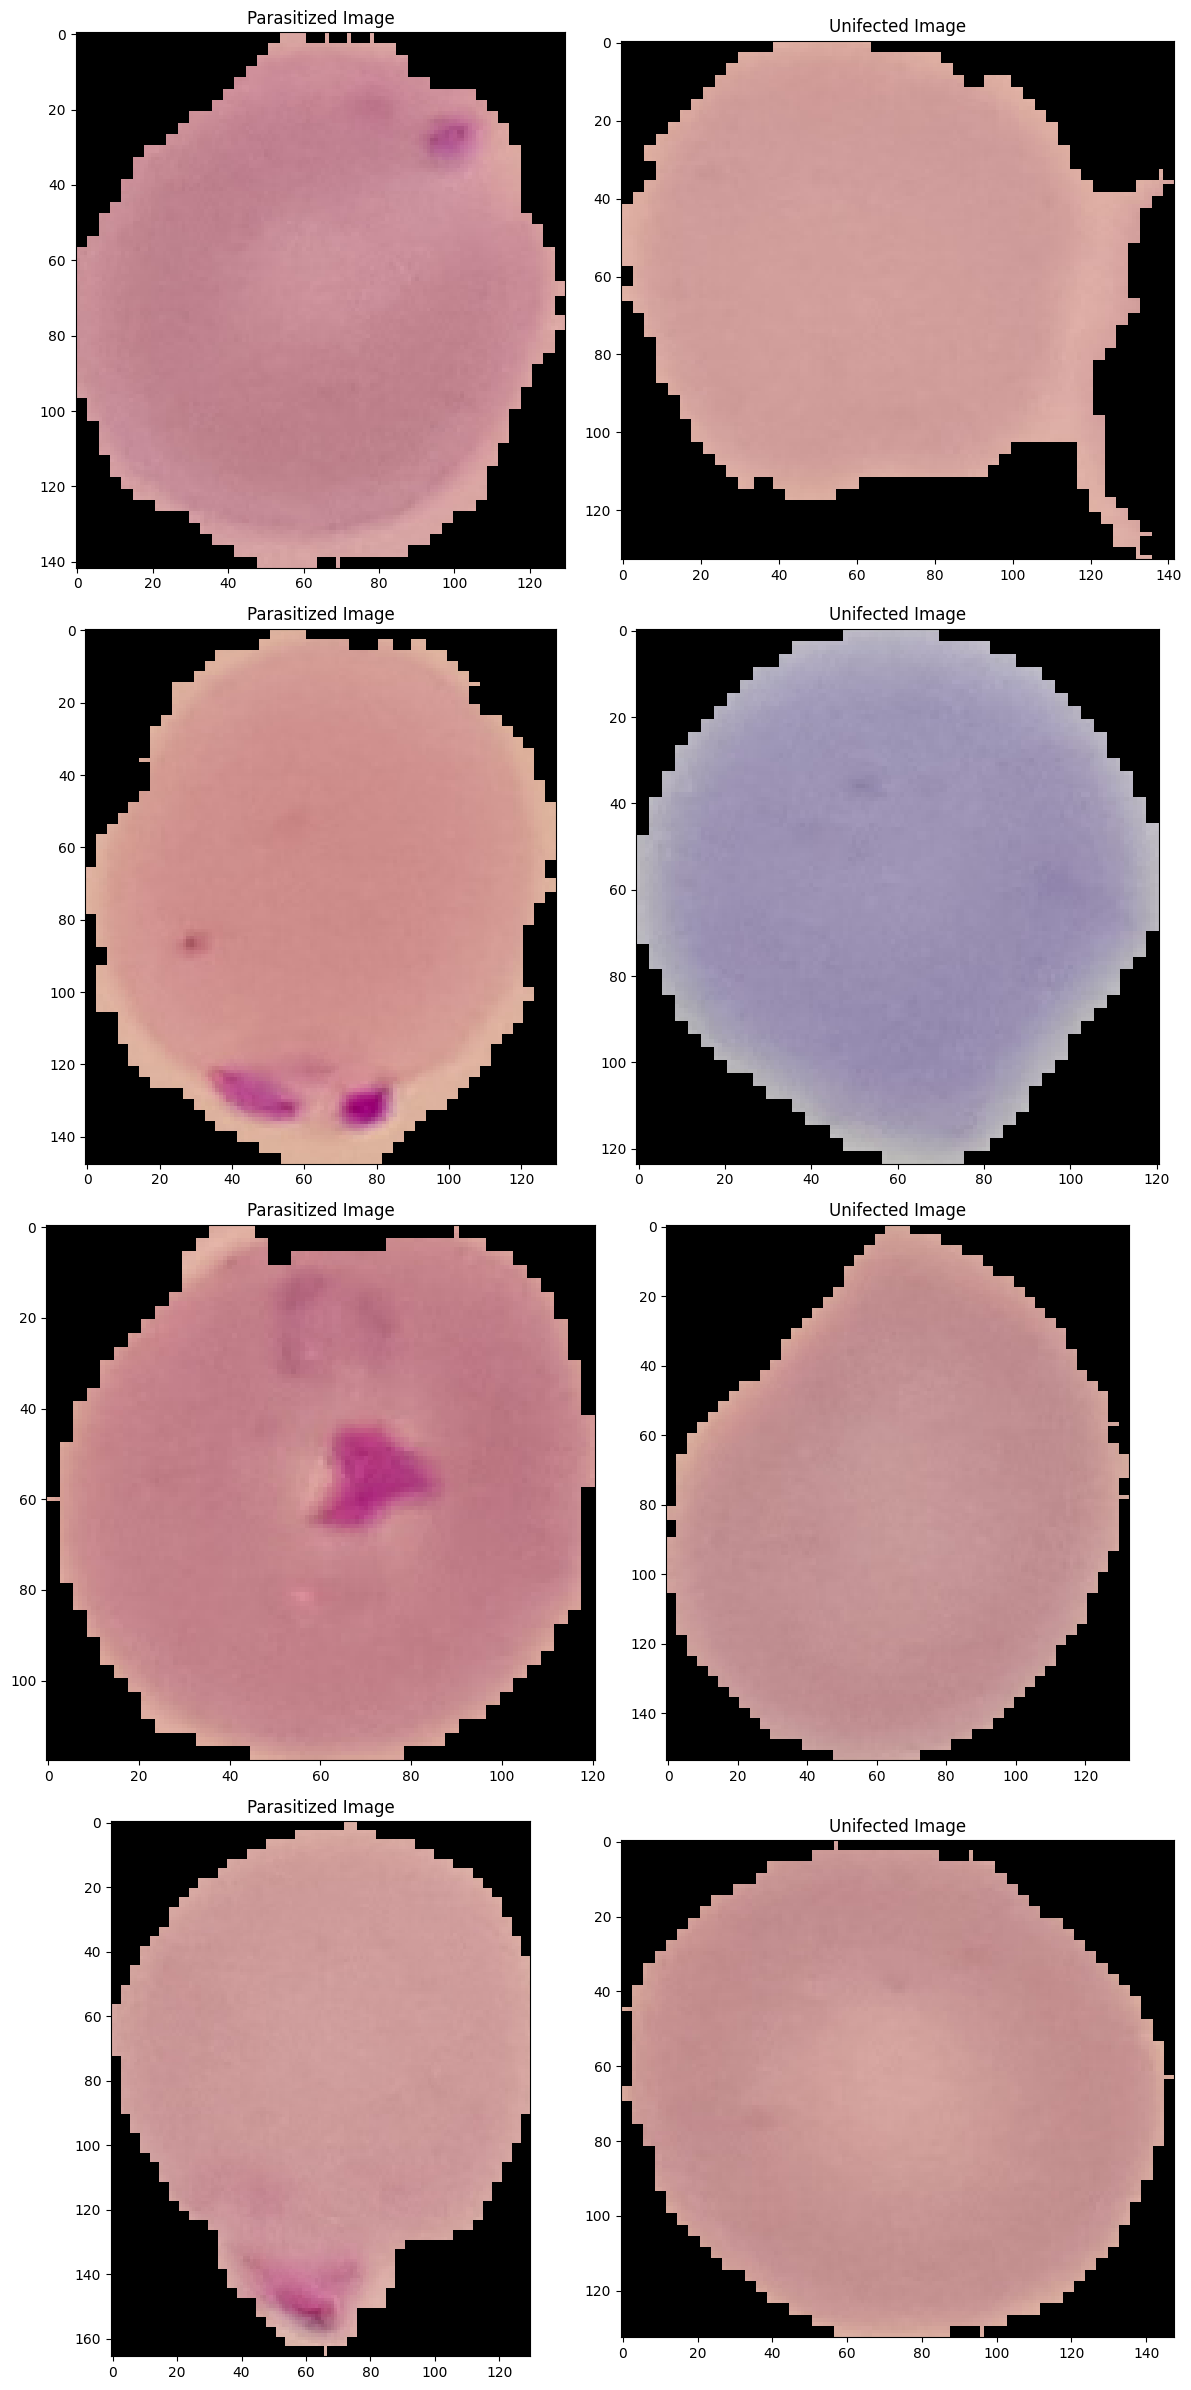

In [9]:
import random
fig, axs = plt.subplots(4,2, figsize=(12,24))
count = 0
for x in range(4):
  i = random.randint(0, len(os.listdir(my_data_dir+'/Parasitized'))) # select a random index
  axs[count][0].title.set_text("Parasitized Image")
  axs[count][0].imshow(imread(my_data_dir+'/Parasitized/'+os.listdir(my_data_dir+'/Parasitized')[i]))
  axs[count][1].title.set_text("Unifected Image")
  axs[count][1].imshow(imread(my_data_dir+'/Uninfected/'+os.listdir(my_data_dir+'/Uninfected')[i]))
  count += 1

fig.tight_layout()


We can see that images of are of different shape so finding out the average dimensions of these images

In [10]:
import os
from skimage.io import imread

dim1 = []
dim2 = []

for image_filename in os.listdir(os.path.join(my_data_dir, 'Uninfected')):
    if image_filename.endswith('.png'):
        img = imread(os.path.join(my_data_dir, 'Uninfected', image_filename))
        d1, d2, colors = img.shape
        dim1.append(d1)
        dim2.append(d2)


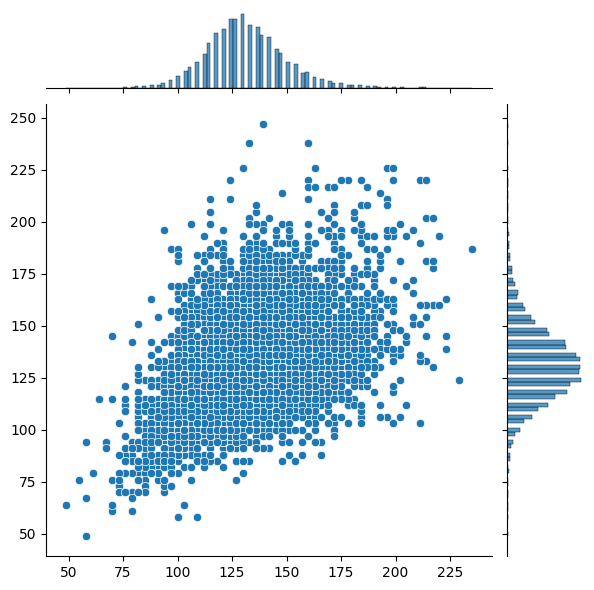

In [11]:
sns.jointplot(x=dim1,y=dim2)

In [12]:
np.mean(dim1)

131.58001306335728

In [13]:
np.mean(dim2)

131.3424776834313

In [14]:
print(f"Max Dimension 1 : {np.max(dim1)} , Min Dimension 1 : {np.min(dim1)}")

Max Dimension 1 : 235 , Min Dimension 1 : 49


In [15]:
print(f"Max Dimension 2 : {np.max(dim2)} , Min Dimension 2 : {np.min(dim2)}")

Max Dimension 2 : 247 , Min Dimension 2 : 49


In [16]:
image_shape =( int( np.mean(dim1) ),int( np.mean(dim2) ), 3 )

## Preparing the Data for the model




### Image Manipulation



In [17]:
train, test = train_test_split(df, test_size = 0.15)
n_classes = 2
batch_size = 32

In [18]:
train_datagen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest', # Fill in missing pixels with the nearest filled value
                               validation_split = 0.30 # set validation split
                              )

test_datagen = ImageDataGenerator(rescale=1/255)

In [19]:
train_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='label',
subset="training",
batch_size=batch_size,
shuffle=True,
class_mode="categorical",
target_size=image_shape[0:2])


valid_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='label',
subset="validation",
batch_size=batch_size,
shuffle=True,
class_mode="categorical",
target_size=image_shape[0:2])


test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='label',
batch_size=batch_size,
shuffle=False,
class_mode='categorical',
target_size=image_shape[0:2])

Found 16397 validated image filenames belonging to 2 classes.
Found 7027 validated image filenames belonging to 2 classes.
Found 4134 validated image filenames belonging to 2 classes.


## Creating the Custom Model

In [20]:
n_classes = 2
batch_size = 32

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=image_shape, name='Conv1'),
    layers.MaxPooling2D((2, 2), name='MaxPool1'),
    layers.Conv2D(64, (3, 3), activation='relu', name='Conv2'),
    layers.MaxPooling2D((2, 2), name='MaxPool2'),
    layers.Conv2D(64, (3, 3), activation='relu', name='Conv3'),
    layers.MaxPooling2D((2, 2), name='MaxPool3'),
    layers.Conv2D(64, (3, 3), activation='relu', name='Conv4'),
    layers.MaxPooling2D((2, 2), name='MaxPool4'),
    layers.Conv2D(64, (3, 3), activation='relu', name='Conv5'),
    layers.MaxPooling2D((2, 2), name='MaxPool5'),
    layers.Flatten(name='Flatten'),
    layers.Dense(64, activation='relu', name='Dense1'),
    layers.Dropout(0.5),                    # Adding Dropout layer with rate 0.5 (50% dropout)
    layers.Dense(32, activation='relu', name='Dense2'),
    layers.Dense(n_classes, activation='sigmoid', name='Output')
])

model.compile(optimizer=Adamax(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1 (Conv2D)                  │ (None, 129, 129, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool1 (MaxPooling2D)         │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 62, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool2 (MaxPooling2D)         │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 29, 29, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool3 (MaxPooling2D)         │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv4 (Conv2D)                  │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool4 (MaxPooling2D)         │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv5 (Conv2D)                  │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool5 (MaxPooling2D)         │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense1 (Dense)                  │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense2 (Dense)                  │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,770 (581.13 KB)

 Trainable params: 148,770 (581.13 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
early_stop = EarlyStopping(monitor='val_loss',patience=10)

checkpointer = ModelCheckpoint(filepath="classifier-custom-CNN-weights.keras", verbose=1, save_best_only=True)

In [22]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.98):
            print("\nReached 98% accuracy so cancelling training!")
            self.model.stop_training = True
            
my_callback = myCallback()

In [ ]:
model.fit(train_generator,epochs=100,
                    validation_data=valid_generator,
                    verbose=1,
                    callbacks=[early_stop,checkpointer,my_callback])

### Evaluating the Model

In [ ]:
#Saving the history
with open('custom_model_history.json', 'w') as f:
    json.dump(model.history.history, f)

In [23]:
# Load the history
with open('/kaggle/input/modle-wights/custom_model_history.json', 'r') as f:
    custom_model_loaded_history = json.load(f)

In [24]:
losses = pd.DataFrame(custom_model_loaded_history)

<Axes: >

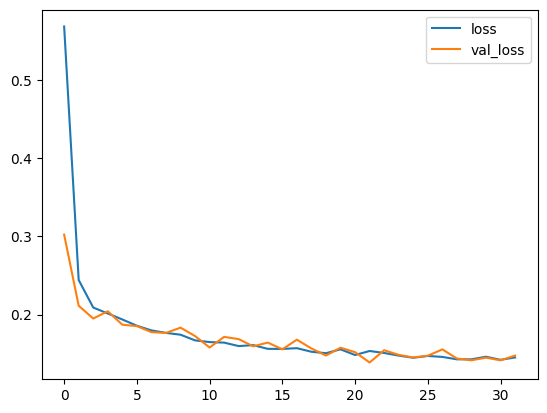

In [25]:
losses[['loss','val_loss']].plot()

In [26]:
model = load_model('/kaggle/input/modle-wights/classifier-custom-CNN-weights.keras')

In [27]:
pred_probabilities = model.predict(test_generator)

2024-07-02 16:32:11.060919: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16641: 6.97677, expected 6.02602
2024-07-02 16:32:11.060975: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16642: 8.06656, expected 7.11581
2024-07-02 16:32:11.060984: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16643: 7.33056, expected 6.3798
2024-07-02 16:32:11.060993: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16644: 7.13004, expected 6.17928
2024-07-02 16:32:11.061000: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16645: 6.48491, expected 5.53415
2024-07-02 16:32:11.061008: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16646: 7.16368, expected 6.21292
2024-07-02 16:32:11.061016: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16647: 6.76936, expected 5.8186
2024-07-02 16:32:11.061024: E

  3/130 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step

I0000 00:00:1719937932.415368     112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


129/130 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step

2024-07-02 16:32:28.744191: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16641: 7.29001, expected 6.40995
2024-07-02 16:32:28.744259: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16645: 7.005, expected 6.12494
2024-07-02 16:32:28.744275: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16646: 7.36079, expected 6.48073
2024-07-02 16:32:28.744293: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16647: 7.33887, expected 6.45881
2024-07-02 16:32:28.744307: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16652: 7.28134, expected 6.40128
2024-07-02 16:32:28.744318: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16653: 6.75958, expected 5.87952
2024-07-02 16:32:28.744329: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16654: 7.40373, expected 6.52367
2024-07-02 16:32:28.744339: E

130/130 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step


In [28]:
pred_probabilities

array([[0.00340185, 0.9962834 ],
       [0.97514004, 0.01717557],
       [0.98842365, 0.00617473],
       ...,
       [0.05285918, 0.94573873],
       [0.94455725, 0.03758569],
       [0.04486037, 0.95088774]], dtype=float32)

In [29]:
# Obtain the predicted class from the model prediction
predict = []

for i in pred_probabilities:
  predict.append(str(np.argmax(i)))

predict = np.array(predict)

In [30]:
true_labels = np.array(test_generator.classes)

# Convert true labels to string format
true_labels = np.array([str(label) for label in true_labels])

In [31]:
print("Classification Report : ",classification_report(true_labels,predict) )

Classification Report :                precision    recall  f1-score   support

           0       0.97      0.96      0.96      2059
           1       0.96      0.97      0.96      2075

    accuracy                           0.96      4134
   macro avg       0.96      0.96      0.96      4134
weighted avg       0.96      0.96      0.96      4134



<Axes: >

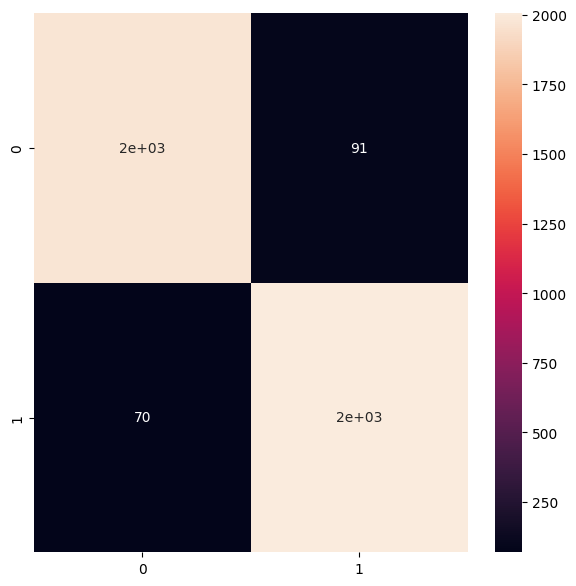

In [32]:
cm = confusion_matrix(true_labels,predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [33]:

# Calculate Accuracy
accuracy = accuracy_score(true_labels,predict)
print(f'Accuracy: {accuracy:.4f}')

# Calculate Precision
precision = precision_score(true_labels,predict, average='weighted')
print(f'Precision: {precision:.4f}')

# Calculate Recall
recall = recall_score(true_labels,predict, average='weighted')
print(f'Recall: {recall:.4f}')

# Calculate F1 Score
f1 = f1_score(true_labels,predict, average='weighted')
print(f'F1 Score: {f1:.4f}')


Accuracy: 0.9611
Precision: 0.9611
Recall: 0.9611
F1 Score: 0.9611


### Using ALexent

In [34]:
# Define AlexNet architecture
alexnet = models.Sequential([
    # 1st Convolutional Layer
    layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=image_shape, padding='valid'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),
    layers.BatchNormalization(),

    # 2nd Convolutional Layer
    layers.Conv2D(256, (5, 5), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),
    layers.BatchNormalization(),

    # 3rd Convolutional Layer
    layers.Conv2D(384, (3, 3), activation='relu', padding='same'),

    # 4th Convolutional Layer
    layers.Conv2D(384, (3, 3), activation='relu', padding='same'),

    # 5th Convolutional Layer
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),

    # Fully Connected Layers
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),

    # Output Layer
    layers.Dense(n_classes, activation='softmax')
])

# Compile the model
alexnet.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
alexnet.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 31, 31, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 15, 15, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 15, 15, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     9,441,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         8,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,979,394 (114.36 MB)

 Trainable params: 29,978,690 (114.36 MB)

 Non-trainable params: 704 (2.75 KB)

In [35]:
early_stop = EarlyStopping(monitor='val_loss',patience=10)

checkpointer = ModelCheckpoint(filepath="classifier-alexnet-weights.keras", verbose=1, save_best_only=True)

In [ ]:
alexnet.fit(train_generator,epochs=100,
                    validation_data=valid_generator,
                    verbose=1,
                    callbacks=[early_stop,checkpointer,my_callback])

Evaluating the Model

In [ ]:
#Saving the history
with open('alexnet_history.json', 'w') as f:
    json.dump(alexnet.history.history, f)

In [36]:
# Load the history
with open('/kaggle/input/modle-wights/alexnet_history.json', 'r') as f:
    alexnet_loaded_history = json.load(f)

In [37]:
losses = pd.DataFrame(alexnet_loaded_history)

<Axes: >

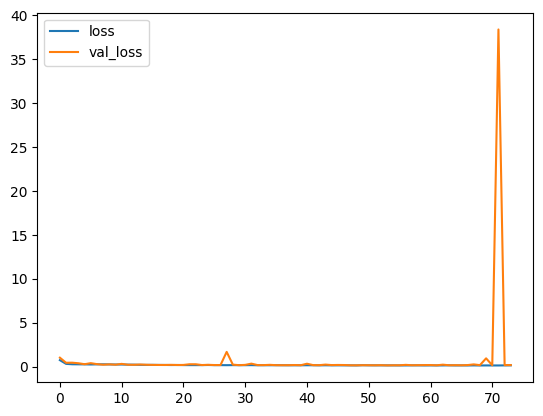

In [38]:
losses[['loss','val_loss']].plot()

In [39]:
alexnet = load_model('/kaggle/input/modle-wights/classifier-alexnet-weights.keras')

In [40]:
pred_probabilities = alexnet.predict(test_generator)

130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step


In [41]:
pred_probabilities

array([[8.4210411e-03, 9.9157894e-01],
       [9.9978757e-01, 2.1238047e-04],
       [9.9879920e-01, 1.2008329e-03],
       ...,
       [1.0372869e-02, 9.8962712e-01],
       [9.9488091e-01, 5.1191226e-03],
       [8.4210327e-03, 9.9157894e-01]], dtype=float32)

In [42]:
# Obtain the predicted class from the model prediction
predict = []

for i in pred_probabilities:
  predict.append(str(np.argmax(i)))

predict = np.array(predict)

In [43]:
true_labels = np.array(test_generator.classes)

# Convert true labels to string format
true_labels = np.array([str(label) for label in true_labels])

In [44]:
print("Classification Report : ",classification_report(true_labels,predict) )

Classification Report :                precision    recall  f1-score   support

           0       0.97      0.96      0.97      2059
           1       0.96      0.97      0.97      2075

    accuracy                           0.97      4134
   macro avg       0.97      0.97      0.97      4134
weighted avg       0.97      0.97      0.97      4134



<Axes: >

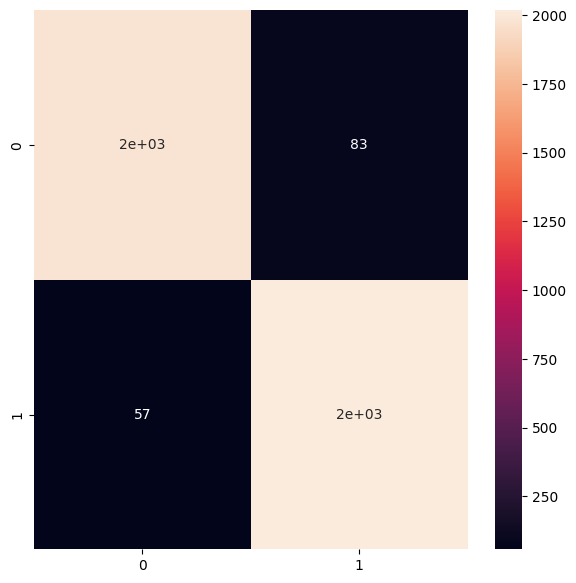

In [45]:
cm = confusion_matrix(true_labels,predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [46]:
# Calculate Accuracy
accuracy = accuracy_score(true_labels,predict)
print(f'Accuracy: {accuracy:.4f}')

# Calculate Precision
precision = precision_score(true_labels,predict, average='weighted')
print(f'Precision: {precision:.4f}')

# Calculate Recall
recall = recall_score(true_labels,predict, average='weighted')
print(f'Recall: {recall:.4f}')

# Calculate F1 Score
f1 = f1_score(true_labels,predict, average='weighted')
print(f'F1 Score: {f1:.4f}')


Accuracy: 0.9661
Precision: 0.9662
Recall: 0.9661
F1 Score: 0.9661
